<a href="https://colab.research.google.com/github/ramtiin/Attention-Based-LSTM-Network-for-Predicting-Times-Series/blob/master/Stock%20Market%20Forecasting%20Using%20FB-Prohet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
 
%matplotlib inline
 
plt.rcParams['figure.figsize']=(16,8)
plt.style.use('ggplot')

In [150]:
prices_df = pd.read_csv('GOOG.csv', index_col='Date', parse_dates=True)
prices_df = prices_df.loc['2017-01-01':,:]

idx = pd.date_range(prices_df.index.min(), prices_df.index.max(), freq='D')
prices_df = prices_df.reindex(idx)
prices_df = prices_df[['Close']]
prices_df = prices_df.rename_axis('Date')

test_size = 100

data_train = prices_df.iloc[:-test_size, :]
data_test = prices_df.iloc[-test_size:, :]

In [151]:
prices_df 

,Close
Date,
2017-01-03,786.140015
2017-01-04,786.900024
2017-01-05,794.020020
2017-01-06,806.150024
2017-01-07,NaN
...,...
2021-05-24,2406.669922
2021-05-25,2409.070068
2021-05-26,2433.530029


In [152]:
data_train.describe()

,Close
count,1038.000000
mean,1198.648664
std,259.151137
min,786.140015
25%,1032.502502
50%,1147.309998
75%,1335.822510
max,2128.310059


,ds,y
1502,2021-02-13,NaN
1503,2021-02-14,NaN
1504,2021-02-15,NaN
1505,2021-02-16,2121.899902
1506,2021-02-17,2128.310059


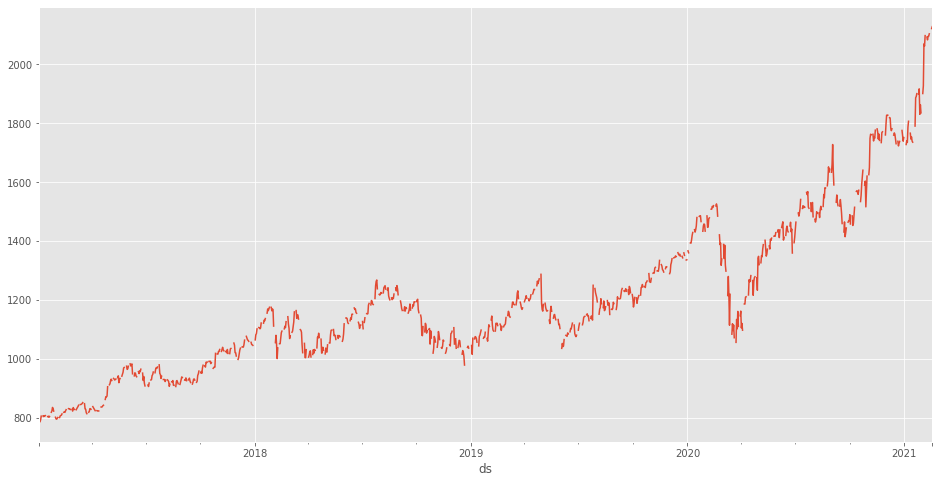

In [153]:
df = data_train.reset_index()
df=df.rename(columns={'Date':'ds', 'Close':'y'})
df['ds'] = pd.to_datetime(df['ds'])
df.set_index('ds').y.plot()
df.tail(5)

In [170]:
model = Prophet(daily_seasonality=True)
model.fit(df)

In [155]:
future = model.make_future_dataframe(periods= int((data_test.index[-1] - data_train.index[-1]).days),freq = 'd')
future.tail(14)

,ds
1593,2021-05-15
1594,2021-05-16
1595,2021-05-17
1596,2021-05-18
1597,2021-05-19
1598,2021-05-20
1599,2021-05-21
1600,2021-05-22
1601,2021-05-23
1602,2021-05-24


In [156]:
# Eliminate weekend from future dataframe
future['day'] = future['ds'].dt.weekday
future = future[(future['day']<5)]
future.tail(14)

,ds,day
1589,2021-05-11,1
1590,2021-05-12,2
1591,2021-05-13,3
1592,2021-05-14,4
1595,2021-05-17,0
1596,2021-05-18,1
1597,2021-05-19,2
1598,2021-05-20,3
1599,2021-05-21,4
1602,2021-05-24,0


In [157]:
forecast = model.predict(future)

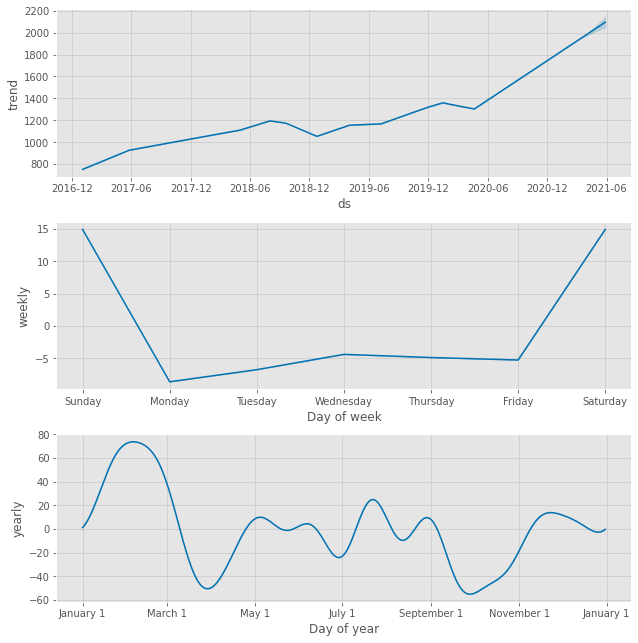

In [158]:
fig = model.plot_components(forecast)

In [159]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2017-01-03,748.715279,675.873939,813.982751
1,2017-01-04,754.220965,681.886076,821.442172
2,2017-01-05,757.104159,691.517252,825.759259
3,2017-01-06,760.298312,687.958910,830.210510
4,2017-01-09,768.792516,699.845949,837.572310
...,...,...,...,...
1144,2021-05-24,2078.253740,1992.566796,2163.685076
1145,2021-05-25,2082.255031,1998.805818,2166.227776
1146,2021-05-26,2086.875797,2004.401558,2174.849932
1147,2021-05-27,2088.759975,2001.649595,2182.519562


In [160]:
new_df = df.set_index('ds')
new_forecast = forecast.set_index('ds')
viz_df = prices_df.join(new_forecast[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')

In [161]:
viz_df

,Close,yhat,yhat_lower,yhat_upper
2017-01-03,786.140015,748.715279,675.873939,813.982751
2017-01-04,786.900024,754.220965,681.886076,821.442172
2017-01-05,794.020020,757.104159,691.517252,825.759259
2017-01-06,806.150024,760.298312,687.958910,830.210510
2017-01-07,NaN,NaN,NaN,NaN
...,...,...,...,...
2021-05-24,2406.669922,2078.253740,1992.566796,2163.685076
2021-05-25,2409.070068,2082.255031,1998.805818,2166.227776
2021-05-26,2433.530029,2086.875797,2004.401558,2174.849932
2021-05-27,2402.510010,2088.759975,2001.649595,2182.519562


In [162]:
prices_df.index = pd.to_datetime(prices_df.index) #make sure our index as a datetime object
connect_date = data_train.index[-2] #select the 2nd to last date
connect_date

Timestamp('2021-02-16 00:00:00', freq='D')

In [163]:
mask = (new_forecast.index > connect_date)
predict_df = new_forecast.loc[mask]

In [164]:
predict_df.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,
2021-02-17,1898.880008,1892.268514,2031.911980,1898.880008,1898.880008,62.630619,62.630619,62.630619,-4.378274,-4.378274,-4.378274,67.008893,67.008893,67.008893,0.0,0.0,0.0,1961.510627
2021-02-18,1900.850498,1893.687610,2032.495251,1900.850498,1900.850498,60.786390,60.786390,60.786390,-4.862635,-4.862635,-4.862635,65.649026,65.649026,65.649026,0.0,0.0,0.0,1961.636888
2021-02-19,1902.820987,1891.825471,2032.967040,1902.820987,1902.820987,58.867447,58.867447,58.867447,-5.250056,-5.250056,-5.250056,64.117503,64.117503,64.117503,0.0,0.0,0.0,1961.688434
2021-02-22,1908.732456,1892.405123,2028.734939,1908.732456,1908.732456,49.759993,49.759993,49.759993,-8.613165,-8.613165,-8.613165,58.373158,58.373158,58.373158,0.0,0.0,0.0,1958.492449
2021-02-23,1910.702945,1894.831220,2024.409000,1910.702945,1910.702945,49.299520,49.299520,49.299520,-6.742349,-6.742349,-6.742349,56.041869,56.041869,56.041869,0.0,0.0,0.0,1960.002466


In [165]:
viz_df = prices_df.join(predict_df[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df.tail(10)

,Close,yhat,yhat_lower,yhat_upper
2021-05-19,2308.709961,2073.916373,1989.800773,2157.548530
2021-05-20,2356.090088,2074.874249,1991.633747,2157.495867
2021-05-21,2345.100098,2076.059118,1994.367334,2158.141966
2021-05-22,NaN,NaN,NaN,NaN
2021-05-23,NaN,NaN,NaN,NaN
2021-05-24,2406.669922,2078.253740,1992.566796,2163.685076
2021-05-25,2409.070068,2082.255031,1998.805818,2166.227776
2021-05-26,2433.530029,2086.875797,2004.401558,2174.849932
2021-05-27,2402.510010,2088.759975,2001.649595,2182.519562
2021-05-28,2411.560059,2090.834451,2006.788144,2170.605439


In [166]:
viz_df.tail(10)

,Close,yhat,yhat_lower,yhat_upper
2021-05-19,2308.709961,2073.916373,1989.800773,2157.548530
2021-05-20,2356.090088,2074.874249,1991.633747,2157.495867
2021-05-21,2345.100098,2076.059118,1994.367334,2158.141966
2021-05-22,NaN,NaN,NaN,NaN
2021-05-23,NaN,NaN,NaN,NaN
2021-05-24,2406.669922,2078.253740,1992.566796,2163.685076
2021-05-25,2409.070068,2082.255031,1998.805818,2166.227776
2021-05-26,2433.530029,2086.875797,2004.401558,2174.849932
2021-05-27,2402.510010,2088.759975,2001.649595,2182.519562
2021-05-28,2411.560059,2090.834451,2006.788144,2170.605439


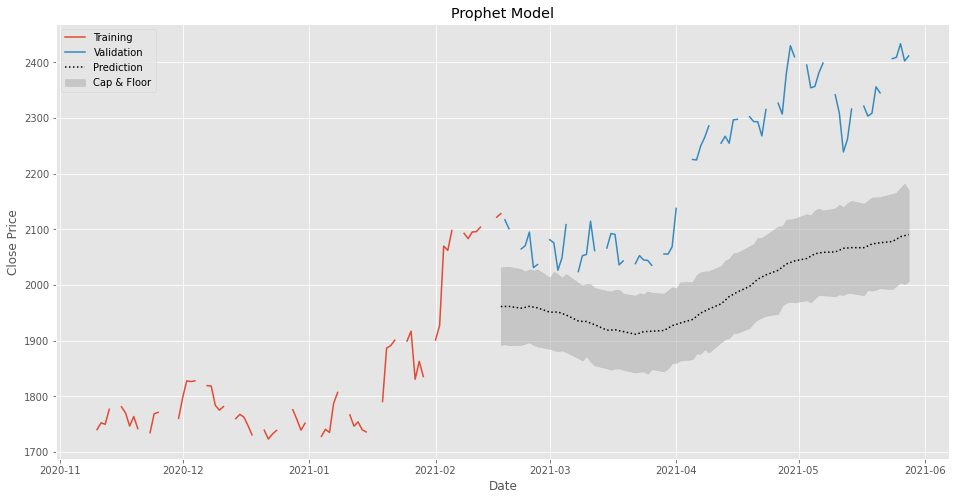

In [167]:
#viz = viz_df.iloc[-400:,:]
fig, ax1 = plt.subplots()
ax1.plot(data_train.iloc[-100:,:].Close)
ax1.plot(data_test.Close)
ax1.plot(predict_df.yhat, color='black', linestyle=':')
ax1.fill_between(predict_df.index, predict_df['yhat_upper'], predict_df['yhat_lower'], alpha=0.5, color='darkgray')
ax1.set_title('Prophet Model')
ax1.set_ylabel('Close Price')
ax1.set_xlabel('Date')
L=ax1.legend(['Training', 'Validation','Prediction', 'Cap & Floor' ]) #get the legend


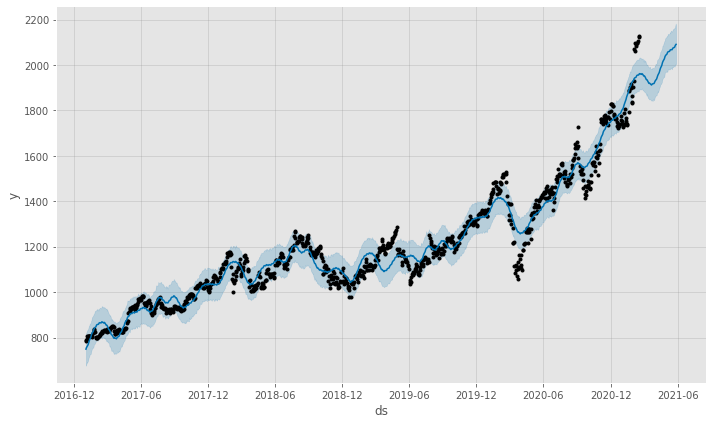

In [168]:
fig1 = model.plot(forecast)

In [169]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
fig = plot_plotly( model, forecast)  
py.iplot(fig)